In [33]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data_pecarn
import data_psrc
import matplotlib.gridspec as grd

# sns.set(style="black")
# plt.style.use('dark_background')
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# look at all dsets

In [50]:
data_file='data_psrc/psrc_data_processed.csv'
df = pd.read_csv(data_file)


NUM_PATIENTS = df.shape[0]
print(NUM_PATIENTS)

# fix col names
df['id'] = np.arange(1, NUM_PATIENTS + 1)
df = df.rename(columns=lambda x: x.replace('choice=0ne', 'choice=None').strip())

2188


In [53]:
df['ageinyrs'] = df['Age in years'].fillna(0) + df['Age in months'].fillna(0) / 12

# drop unnecessary
df = df.drop(columns=['Record ID',  'Arrival time in ED', 'Age', 'Age in months', 'Age in years',])

In [67]:
df = df.rename(columns={'Seatbelt sign': 'SeatBeltSign', 
                        'Initial GCS': 'GCSScore',
                        'Lower chest wall/costal margin tenderness to palpation  (choice=1 on left)': 'LtCostalTender',
                        'Lower chest wall/costal margin tenderness to palpation  (choice=1 on right)': 'RtCostalTender'
                       })

In [65]:
df.SeatBeltSign.sum()

143

In [73]:
# these need matching
df = df.rename(columns={'Abdominal distension': 'AbdDistention'})

In [68]:
list(df.keys())

['Race',
 'Hispanic ethnicity',
 'Mechanism of injury (choice=Assault/struck)',
 'Mechanism of injury (choice=ATV injury)',
 'Mechanism of injury (choice=Bike crash)',
 'Mechanism of injury (choice=Bike struck by auto)',
 'Mechanism of injury (choice=Fall > 10 ft. height)',
 'Mechanism of injury (choice=Golf cart injury)',
 'Mechanism of injury (choice=Motorcycle/dirt bike crash)',
 'Mechanism of injury (choice=MVC)',
 'Mechanism of injury (choice=Pedestrian struck by auto)',
 'Mechanism of injury (choice=Other blunt mechanism)',
 'If bike crash, landed on handle bar',
 'MVC details (choice=>40 MPH)',
 'MVC details (choice=Ejection)',
 'MVC details (choice=Rollover)',
 'MVC details (choice=Prolonged extrication)',
 'MVC details (choice=Unrestrained)',
 'MVC details (choice=Death in vehicle)',
 'MVC details (choice=0t reported)',
 'Other mechanism of injury',
 'Alert level',
 'Complainabd. pain',
 'Emesis post injury',
 'Intubated prior to arrival',
 'Intubated during trauma resuscitati

In [69]:
PECARN_FEAT_NAMES = ['SeatBeltSign', 'ageinyrs', 'LtCostalTender', 'RtCostalTender']

In [ ]:
df[PECAR]

In [8]:
# pecarn feats
'''
['AbdDistention',
 'AbdTenderDegree',
 'AbdTrauma',
 'AbdTrauma_or_SeatBeltSign',
 'AbdomenPain',
 'Costal',
 'DecrBreathSound',
 'DistractingPain',
 'GCSScore',
 'LtCostalTender',
 'RecodedMOI',
 'RtCostalTender',
 'SeatBeltSign',
 'ThoracicTender',
 'ThoracicTrauma',
 'VomitWretch',
 'ageinyrs']
'''
# InjuryMechanism_1, hypotension?, femure fracture

# outcomes
iai_keys = [k for k in df.keys() if 'Interventions for IAI' in k]
iai_with_intervention_keys = [k for k in iai_keys if not 'choice=None' in k]
outcomes = ['Admission', 
            'ICU admission', 
            'Length of inpatient stay (days)',
            'Delayed inpatient diagnosis of IAI (more than 24 hours after admission)',
            'Mortality (within 30 days of injury)',
            'Mortality related to trauma',
            'Mortality secondary to intra-abdominal injury',
            'Missed diagnosis of IAI (following discharge)'] + iai_keys

In [9]:
# iai
df['iai'] = df[iai_keys].sum(axis=1) > 0
df['iai_with_intervention'] = df[iai_with_intervention_keys].sum(axis=1) > 0

In [28]:
# pecarn feats
useful_feats = ['ageinyrs']

In [3]:
features = data.get_features() # uses several forms
outcomes = data.get_outcomes() # 2 outcomes: iai, and iai_intervention
df = pd.merge(features, outcomes, on='id', how='left')
# df = rename_values(df)
# df = data.preprocess(features) # process the feats (should save into df)

100%|██████████| 49/49 [00:01<00:00, 41.03it/s]
48it [00:02, 16.77it/s]


final shape (12044, 433)


### eda plots

In [4]:
fnames = df.keys()
missing_arr = np.zeros((len(fnames), data.NUM_PATIENTS + 1), dtype=np.bool)

for i, fname in enumerate(fnames):
#     df = r[fname]
    ids = np.unique(df.id.values)
#     print(np.min(ids), np.max(ids))
    missing_arr[i, ids] = 1

In [ ]:
plt.figure(figsize=(5, 10))
sns.barplot(x=missing_arr.sum(axis=1), y=fnames, orient='h')
plt.xlabel('number of patients')
plt.show()

In [ ]:
# plt.imshow(not_missing)
plt.figure(figsize=(12, 20), dpi=300)
sns.clustermap(missing_arr, yticklabels=fnames)
# plt.tight_layout()
plt.show()

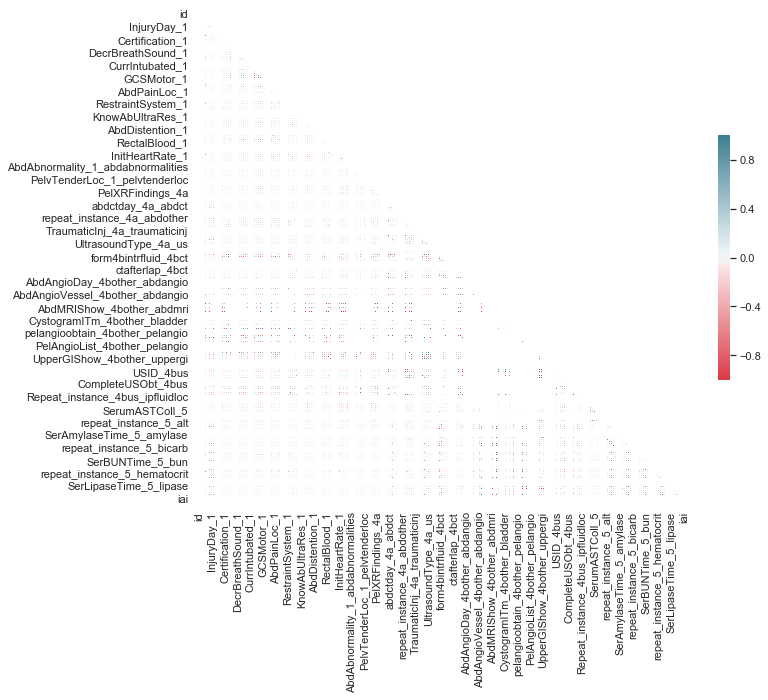

In [26]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
# sns.clustermap(corr) #, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

# look at demographics

In [19]:
# demographics = pd.read_csv('iaip_data/Datasets/demographics.csv').rename(columns={'SubjectID': 'id'})
# ids_np = np.array(list(ids)) - 1
ids_np = df.iai_intervention == 1
# vals = demographics.values[ids_np]
# print(list(demographics))
print(df.keys()[:10])

Index(['id', 'SEX', 'RACE', 'OTHER_RACE', 'HISPANIC_ETHNICITY', 'ageinyrs',
       'EDTriageDay_1', 'EDTriageTime_1', 'InjuryDay_1', 'InjuryTime_1'],
      dtype='object')


In [21]:
# the mean age is the only one which is wrong
print('age', np.mean(df.ageinyrs[ids_np]), np.mean(df.ageinyrs))
print('age<2', np.sum(df.ageinyrs[ids_np] < 2), np.sum(df.ageinyrs < 2))
print('sex', np.sum(df.SEX[ids_np] == 'M'), np.sum(df.SEX == 'M'))
print('hispanic ethnicity', np.sum(df.HISPANIC_ETHNICITY[ids_np] == 0), np.sum(df.HISPANIC_ETHNICITY == 0))

age 9.339901477832512 9.767270009963468
age<2 10 1167
sex 125 7384
hispanic ethnicity 119 7656
